## Uncertainty ranking figures for semantic segmentation experiments

To make the plots, you first need to train or download models trained with cross-entropy and with label-smoothing. Then, update the following variables with values corresponding to your own experiments:

In [1]:
# Paths
MODEL_CE_PATH = "../experiments/segmentation/logs/deeplab/version_0/checkpoints/last.ckpt"
MODEL_LS_PATH = "../experiments/segmentation/logs/deeplab_ls/version_0/checkpoints/last.ckpt"
ls_value = 0.2

# Choose your device

DEVICE = "cuda:0"

# Whether to save the images or not

SAVE_IMG = False

Prepare the datamodule and disable gradients. You may need to reduce the batch size if you have a small GPU than mine.

In [2]:
import torch
from torch_uncertainty.datamodules.segmentation import CityscapesDataModule

torch.set_grad_enabled(False)
height = 1024
width = 2048
dm = CityscapesDataModule(root="../experiments/segmentation/data/Cityscapes", batch_size=10, num_workers=2)
dm.setup("test")
val_dst = dm.test_dataloader()[0].dataset

/home/soumik/miniconda3/envs/tu/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Instantiate the models in memory; the losses will not be taken into account here but are needed to instantiate the models without errors.

In [3]:
from torch_uncertainty.models.segmentation.deeplab import deep_lab_v3_resnet101
from torch_uncertainty.routines import SegmentationRoutine

model = deep_lab_v3_resnet101(19, "v3+", pretrained_backbone=False)
model = model.to(DEVICE)
routine = SegmentationRoutine.load_from_checkpoint(MODEL_CE_PATH, model=model, loss="torch.nn.CrossEntropyLoss")
routine.model = routine.model.to(DEVICE)
routine.eval()

model_ls = deep_lab_v3_resnet101(19, "v3+", pretrained_backbone=False)
model_ls = model_ls.to(DEVICE)
routine_ls = SegmentationRoutine.load_from_checkpoint(MODEL_LS_PATH, model=model_ls, loss="torch.nn.CrossEntropyLoss")
routine_ls.model = routine_ls.model.to(DEVICE)
routine_ls.eval();

#### Create the color bar and prepare the normalization

In [4]:
import torch
from matplotlib import cm

cbar = cm.get_cmap("viridis")
mean = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])

/tmp/ipykernel_1655495/2117819333.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cbar = cm.get_cmap("viridis")


In [5]:
# Select an image of the validation set: 8 is the main scene used in the paper
img_id = 8

#### Compute & show the rank ordering plot

In [14]:
height = 256
width = 512
min_height, max_height = int(0.2 * height), int(0.8 * height)
min_width, max_width = int(0.03 * width), int(0.97 * width)

routines = [routine, routine_ls]
heights = {"min": min_height, "max": max_height, "full": height}
widths = {"min": min_width, "max": max_width, "full": width}
stats = {"mean": mean, "std": std}

Plot the segmentation figure including the rankings of uncertainty. You may find a small documentation and comments on how this is computed in the `torch_uncertainty_ls/utils.py` file.

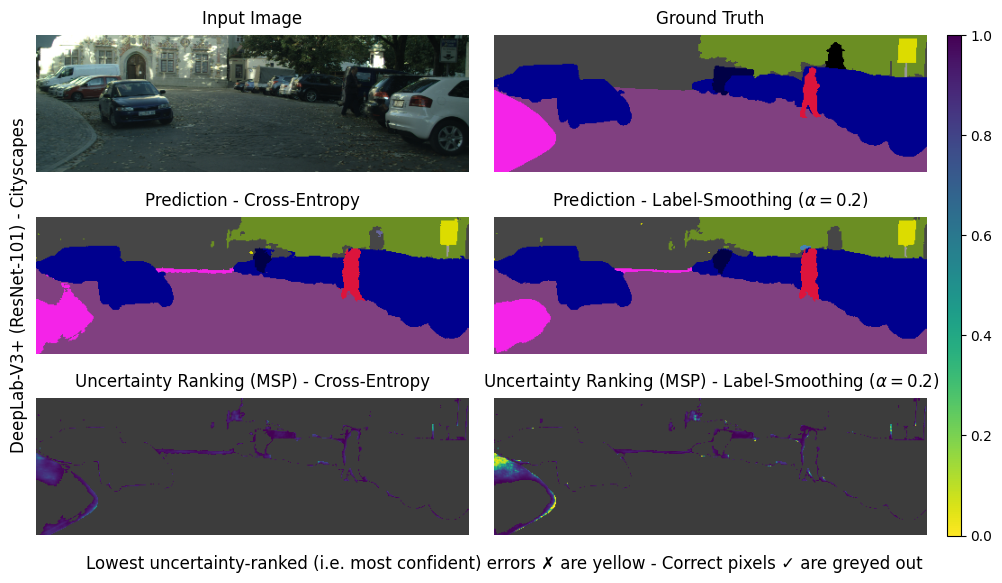

In [ ]:
from torch_uncertainty_ls.utils import plot_segmentation_figure

plot_segmentation_figure(val_dst, routines, DEVICE, ls_value, cbar, heights, widths, stats, img_id, save=SAVE_IMG, full_plot=False)

### Make the norm-logits plots

Please always run `plot_segmentation_figure` before `plot_segmentation_normalization` to avoid results/get correct plots when you change the id of the image or other parameters.

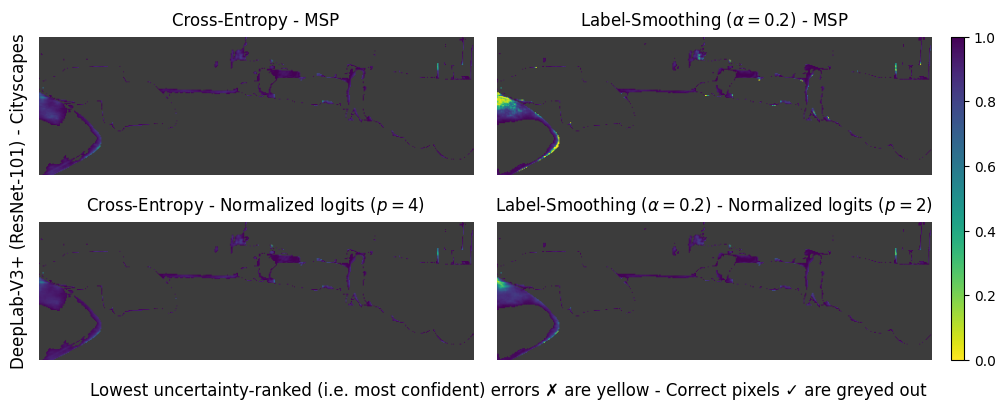

In [ ]:
from torch_uncertainty_ls.utils import plot_segmentation_normalization

normalization_dimension = 2

plot_segmentation_normalization(
    normalization_dimension,
    ls_value,
    cbar,
    heights,
    widths,
    img_id,
    norm_dimension_ce=4,
    add_unit="mean",
    save=SAVE_IMG,
    full_plot=False,
)

Make all the plots for the first 16 images:

In [17]:
from tqdm.auto import tqdm

for i in tqdm(range(16)):
    plot_segmentation_figure(
        val_dst, routines, DEVICE, ls_value, cbar, heights, widths, stats, i, save=True, full_plot=True, plot=False
    )
    plot_segmentation_normalization(
        normalization_dimension, ls_value, cbar, heights, widths, i, norm_dimension_ce=4, add_unit="mean", save=True, full_plot=True, plot=False
    )

100%|██████████| 16/16 [00:36<00:00,  2.28s/it]
